In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def int_spec_SII(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y):
    y = np.sum(np.sum(wo_cube[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2],axis=1),axis=1)
    y_err = np.sqrt(np.sum(np.sum(((wo_err[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]))**2,axis=1),axis=1))
    return y,y_err

def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6850*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact
    

In [58]:
def popt_central_fit(wo_wave,data,error,obj,z,p_init):
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    popt_full_fit,pcov_full_fit = leastsq(test_gauss_SII,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(test_gauss_SII,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
        parameters_err = np.std(parameters_MC,1)  
    (amp_SII6716_error,amp_SII6731_error,vel_SII6731_error,vel_sigma_SII6731_error,amp_SII6716_br_error,amp_SII6731_br_error,vel_SII6731_br_error,vel_sigma_SII6731_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 



In [106]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_fit,c_fit) = popt_full_fit
    offset_fit=0.0

    k = 1+z
    new_k = 1+ (vel_SII6731_fit/300000)
    select = (wo_wave>6690*new_k) & (wo_wave < 6760*new_k)
    
    fit = test_gauss_SII(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit

    plt.style.use('ggplot')
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(10, 9)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
    ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

    plt.setp(ax1.get_xticklabels(), visible=False)  
    #ax1.xaxis.set_ticks_position('bottom') 
    #ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    ax1.plot(wo_wave[select]/new_k,data[select],'k-',drawstyle='steps-mid',label='Spectrum')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Model')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select]+offset_fit,m_fit,c_fit) + SII_doublet_gauss(wo_wave[select]+offset_fit,amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit),'g--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select]+offset_fit,m_fit,c_fit) + SII_doublet_gauss(wo_wave[select]+offset_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit),'b:',label='Broad wing')
    ax1.set_xlim(6700,6750)
    ax1.set_ylim(22,40)
    ax1.annotate('[SII] 6731',xy=(6732,25.0),xytext=(6741,35),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate('[SII] 6716',xy=(6716,26.1),xytext=(6701,33),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    #ax1.legend(fontsize=17)
    ax1.legend(facecolor='white', framealpha=1, fontsize=17, loc='upper left')

    ax2.plot(wo_wave[select]/new_k,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='r', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.5, color='darkgray')
    ax2.set_xlim(6700,6750)
    ax2.set_ylim(-9.5,9.5)    
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
    ax2.legend(fontsize=17)
   
    plt.tight_layout(pad=0.001, h_pad=0.001, w_pad=None)
    fig.savefig('%s/Spectrum/%s/SII/%s_[SII]_model_residual.png'%(destination_path_cube,obj,obj),overwrite=True)    

In [107]:
def algorithm_script(obj,p_init,z,prefix_path_cube="/media/rickeythecat/Seagate/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj))
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    print (brightest_pixel_x,brightest_pixel_y)
    (data,error) = int_spec_SII(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y)
    
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    print (factor)
    error = factor*error
        
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,z,p_init)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit)
    


HE0253-1641
96 41
2.593429


No handles with labels found to put in legend.


[ 8.70098275e+00  7.31876951e+00  9.59775173e+03 -8.65659211e+01
  2.72426787e+00  5.00300775e+00  9.48935915e+03  1.98771467e+02
 -1.83979066e+01  1.51024748e+02] [ 0.37667958  1.03246606  6.2641152   4.03511389  0.49273564  0.9112244
 20.26064638 22.77672225  3.31039273 23.00129579]


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


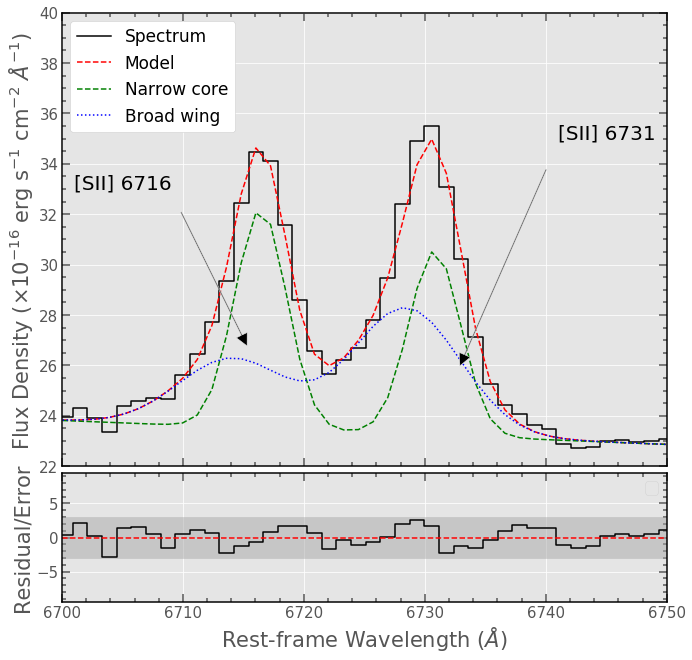

In [108]:
z = {"HE0253-1641":0.031588}

objs = z.keys()

p_init = {'HE0253-1641':[5,5,9476,50,2,2,9276,100,-0.001,0.1]}



for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj]) 
